# Homework 2
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

Bạn đã được học qua phương pháp phát hiện đường biên trong phần lý thuyết. Bài tập này sẽ giúp các bạn tự ôn tập và đánh giá về Phát hiện đường biên (Edge Detector) với bộ phương pháp Canny và Biến đổi Hough (Hough Transformation).

In [1]:
# Setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

print ("Tran Hoang Thao Nguyen (B1509938)")
print ("Truong Gia Huy (B1509864)")
print ("Huynh Them Loc (B1509930)")
print ("Nguyen Anh Duy (B1509854)")

Tran Hoang Thao Nguyen (B1509938)
Truong Gia Huy (B1509864)
Huynh Them Loc (B1509930)
Nguyen Anh Duy (B1509854)


## Part 1: Canny Edge Detector (85 points)
In this part, you are going to implement Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:

Trong phần này, bạn sẽ cài đặt bộ phát hiện đường biên Canny. giải thuật phát hiện đường biên Canny có thể được chia thành 5 bước sau:

1. Smoothing: làm mịn/trơn ảnh (lọc hạ thông với mặt nạ Gauss)
2. Finding gradients (Tính gradients bằng cách tính đạo hàm theo x và theo y)
3. Non-maximum suppression (Xoá bỏ các điểm mà tại đó giá trị của gradient không lớn nhất)
4. Double thresholding (Phân ngưỡng kép để tìm strong edges và weak edges)
5. Edge tracking by hysterisis (Liên kết các điểm trên đường biên bằng cách xét các lân cận của strong edges)

### 1.1 Smoothing (10 points)
#### Implementation (5 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

Trước hết ta sẽ làm trơn/mịn ảnh đầu vào bằng cách chập mặt nạ Gauss lên ảnh. Hàm Gauss là một hàm liên tục, để có thể chập nó lên ảnh cần phải xấp xỉ (rời rạc hoá) nó. Công thức tính mặt nạ Gauss kích thước $(2k+1)\times(2k+1)$ như sau:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** in `edge.py` and run the code below.
Hãy cài đặt hàm **`gaussian_kernel`** trong `edge.py` để sinh ra một mặt nạ chập tương ứng và chạy đoạn code bên dưới.

Nếu bạn cài đặt đúng, hai ma trận **`kernel`** và **`kernel_test`** sẽ có cùng giá trii.

In [3]:
from edge import conv, gaussian_kernel

# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

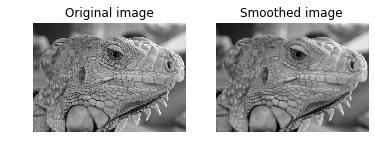

In [4]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the effect of the kernel_size and sigma?
Ảnh hưởng của tham số **`kernel_size`** và **`sigma`** như thế nào lên ảnh kết quả?

**Your Answer:** Write your solution in this markdown cell.

Sigma càng lớn và kernel_size càng lớn thì ảnh càng mờ. (mịn)

### 1.2 Finding gradients (15 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

Trên đây là các công thức tính đạo hàm riêng của ảnh theo hướng x và hướng y. Phép tính đạo hàm trên ảnh tương đương với việc chập mặt nạ $D_x$ (và $D_y$) lên ảnh $I$ để được $\frac{\partial{I}}{\partial{x}}$ (và $\frac{\partial{I}}{\partial{y}}$).

Hãy xem lại các slides lý thuyết (slides 49 - 50). Có 3 cách xấp xỉ để tính đạo hàm riêng của ảnh theo một hướng (ví dụ: hướng $x$). Trong bài thực hành nay, ta sử dụng cách thứ 3.

#### Implementation (5 points)
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined in `edge.py`.

Hãy tìm 2 mặt nạ $D_x$ và $D_y$. Sau đó cài đặt 2 hàm **`partial_x`** and **`partial_y`** bằng cách gọi hàm `conv` đã được định nghĩa trong `edge.py`.

*-Hint: Remeber that convolution flips the kernel.*

*-Gợi ý: Hãy nhó là phép toán tích chập cần phải lật mặt nạ (theo cả 2 chiều) trước khi nhân các phần tử tương ứng với nhau.*


In [5]:
from edge import partial_x, partial_y

# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

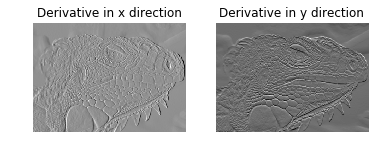

In [6]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the reason for performing smoothing prior to computing the gradients?

Tại sao cần phải làm mịn/trơn ảnh trước khi tính gradients ?

**Your Answer:** Write your solution in this markdown cell.

Bởi vì nếu ảnh có nhiều nhiễu, kết quả của gradients sẽ không chính xác. 

#### Implementation (5 points)
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

Sau khi đã có gradients (gồm hai đạo hàm riêng $G_x$ và $G_y$), giờ ta sẽ tính độ lớn và hướng của gradient từ $G_x$ và $G_y$.
$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** in `edge.py` which takes in an image and outputs $G$ and $\Theta$.

Hãy cài đặt hàm **`gradient`** trong `edge.py`. Hàm này nhận đầu vào là một ảnh và trả về hai ma trận $G$ và $\Theta$.

*-Hint: Use np.arctan2 to compute $\Theta$.*

*-Gợi ý: Dùng np.arctan2 tính góc $\Theta$. Cần phải chú ý: hàm arctan2 của numpy trả về radiant chứ không phải độ. Kết quả trả về một số thực từ $-\pi$ đến $\pi$. Bạn cần phải đổi nó ra độ bằng cách nhân với 180/np.pi.*


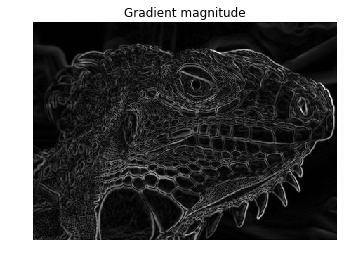

In [7]:
from edge import gradient

G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')
    
plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 1.3 Non-maximum suppression (15 points)
You should be able to note that the edges extracted from the gradient of the smoothed image is quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:

Bạn cần phải chú ý rằng đường biên được trích ra từ gradient của ảnh đã được làm mịn/trơn thường rất dày (đậm nét) và nhoè. Mục đích của bước tiếp theo đây là chuyển từ một đường biên "nhoè" sang đường biên "sắc nét". Việc này được thực hiện bằng cách chỉ giữ lại các điểm cực trị (cục bộ) và bỏ hết các điểm khác. Giải thuật xác định điểm (x,y) trên ảnh graident có phải là điểm cực trị không gồm các bước sau:

1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

Trong hàm **`gradient`**, giá trị trả về của $\Theta[x, y]$ là một số thực từ $0^o$ đến $360^o$. Bạn cần phải làm tròn số về bội số gần nhất của $45^o$ tương ứng với 1 trong 8 hướng (0, 45, 90, 135, 180, 225, 270, 315) hay tương ứng với 8 lân cận của 1 pixel. Ví dụ: nếu $\Theta[x, y] = 15^O$ ta làm tròn nó về $0^o$, $\Theta[x, y] = 100^O$ ta làm tròn nó về $90^o$, ... Công thức làm tròn số đã được cho trong code:
$$theta = np.floor((theta + 22.5) / 45) * 45$$

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient direction. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

So sánh độ lớn của gradient tại điểm đang xét (x,y) và gradient của hai điểm trên (x', y') và dưới (x'', y'') theo hướng của gradient. Độ lớn của gradient tại điểm (x,y) chính là G[x,y].

$$
\begin{vmatrix}
125 & 270 & 315\\
180 &   .   &  0\\
135 & 90  & 45
\end{vmatrix}
$$
Ví dụ: Giả sử điểm đang xét là (x,y) và $\Theta[x, y] = 90^O$ (hướng xuống) thì (x', y') = (x, y+1) và (x'', y'') = (x, y-1). Xem thêm các slides 100-101.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Nếu độ lớn của gradient tại điểm đang xét lớn nhất thì giữ nó lại (copy giá trị của nó vào ma trận out). Nếu không, loại bỏ điểm này đi (bỏ qua, không cần làm gì cả vì khi khởi tạo tât cả các pixel của out có giá trị 0).

Implement **`non_maximum_suppression`** in `edge.py`

Hãy cài đặt hàm **`non_maximum_suppression`** trong `edge.py`

In [8]:
from edge import non_maximum_suppression

# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))

Thetas: 0
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]
Thetas: 45
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.4 0.5 0.6]]
Thetas: 90
[[0.4 0.5 0. ]
 [0.  0.5 0.7]
 [0.4 0.5 0. ]]
Thetas: 135
[[0.4 0.5 0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]


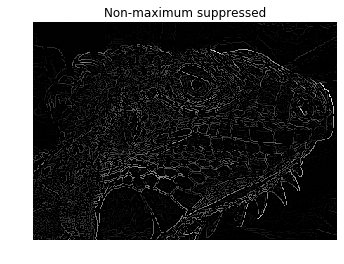

In [9]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

### 1.4 Double Thresholding (20 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Mỗi điểm ảnh còn lại sau bước 1.3 (loại bỏ các điểm không phải cực trị) hiện đang giữ độ lớn của gradient tại điểm này. Đa phần các điểm này là các đường biên thực sự, nhưng cũng có thể tồn tại một số điểm không phải đường biên (do nhiễu, do sự thay đổi màu, bề bặt đối tượng gồ ghề). Cách đơn giản nhất để loại bỏ chúng là dùng ngưỡng sao cho chỉ hiwax lại các điểm thực sự là đường biên. Giải thuật Canny sử dụng phương pháp phân ngưỡng kép. Những pixel có giá trị lớn hớn ngưỡng cao sẽ được đánh dấu là **strong** (đường biên thực sự); những pixel có giá trị nhỏ hơn ngưỡng thấp sẽ bị xoá bỏ vì nó không phải là đường biên (sự thay đổi mức xám không đủ lớn); những điểm có giá trị nằm giữa hai ngưỡng sẽ được đánh dấu là **weak** (có thể là đường biên và cũng có thể không là đường biên tuỳ thuộc vào xung quanh nó).

Implement **`double_thresholding`** in `edge.py`

Hãy cài đặt hàm **`double_thresholding`** trong `edge.py`


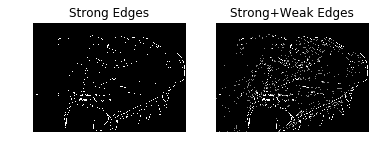

In [10]:
from edge import double_thresholding

low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 1.5 Edge tracking (15 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Weak edges are included if and only if they are connected to strong edges. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed in dependently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Các điểm được đánh dấu là **strong** thì nó chắc chắn là đường biên và ta có thể đưa nó vào ảnh đường biên kết quả. Những điểm được đánh dấu là **weak** sẽ được đưa vào ảnh kết quả nếu nó liên thông (có chung đỉnh với) một điểm được đánh dấu **strong**.

Implement **`link_edges`** in `edge.py`

Hãy cài đặt hàm **`link_edges`** trong `edge.py` sử dụng ý tưởng sau:

Sử dụng một hàng đợi Q
- Đưa tất cả các điểm (chỉ cần lưu 2 chỉ số (x, y) của nó) được đánh dấu là strong vào trong Q, đánh dấu nó đang xét
- while (Q chưa rỗng)
    - lấy điểm (x, y) đầu hàng đợi ra
    - đưa (x,y) vào ảnh kết quả (out[y, x] = 1)
    - lấy lân cận của (x, y) sử dụng hàm getneighbour(y, x, H, W)
    - với mỗi điểm lân cận của (x, y) kiểm tra nếu nó là **weak** và nó chưa được xét thì đưa nó vào hàng đợi và đánh dấu nó đang xét.





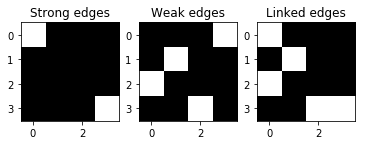

In [11]:
from edge import get_neighbors, link_edges

test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]]
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]]
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

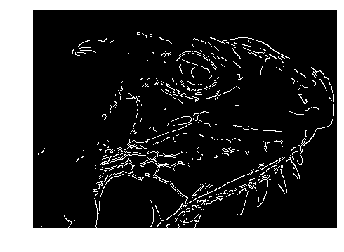

In [12]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

### 1.6 Canny edge detector
Implement **`canny`** in `edge.py` using the functions you have implemented so far. Test edge detector with different parameters.

Here is an example of the output:

Hãy cài đặt hàm **`canny`** trong `edge.py` sử dụng các hàm đã cài đặt trước đó. Kiểm tra bộ phát hiện đường biên với các tham số khác nhau.

Bên dưới là một ví dụ. Cố gắng điều chỉnh sao cho kết quả của bạn giống với ví dụ:

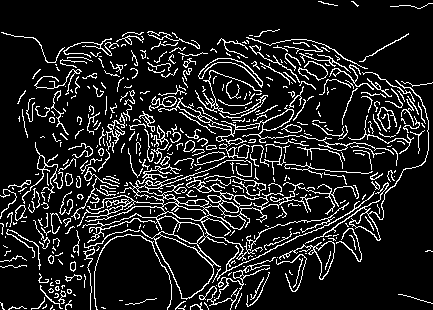


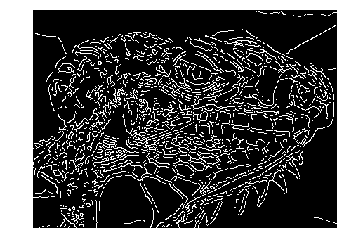

In [13]:
from edge import canny

# Load image
img = io.imread('iguana.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=0.5, high=0.35, low=0.15)
# print (edges.shape)
plt.imshow(edges)
plt.axis('off')
plt.show()

### 1.7 Question (10 points)

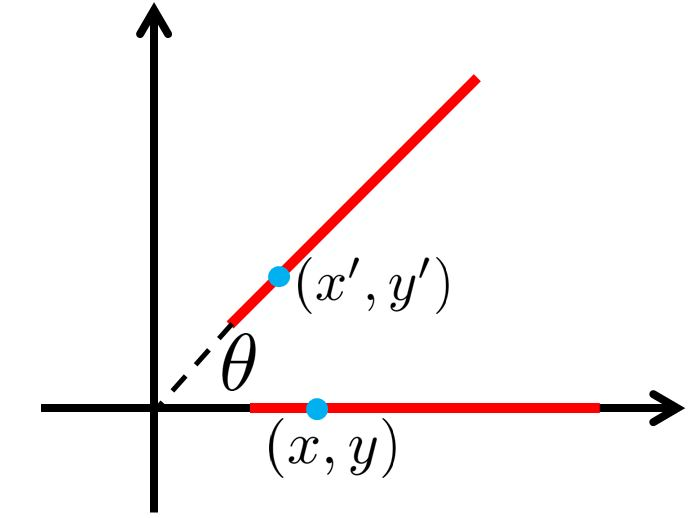
**(a)** Suppose that the Canny edge detector successfully detects an edge in an image. The edge (see the figure above) is then rotated by θ, where the relationship between a point on the original edge $(x, y)$ and a point on the rotated edge $(x', y')$ is defined as

Giả sử rằng bộ phát hiện đường biên Canny thành công trong việc tìm đường biên trong ảnh. Đường biên (xem trong hình bên dưới) được quay một góc $\theta$, mối quan hệ giữa toạ độ của điểm trước và sau khi quay được cho trong phương trình:

$$
x'=x\cos{\theta}\\
y'=x\sin{\theta}
$$

Will the rotated edge be detected using the same Canny edge detector? Provide either a mathematical proof or a counter example.

Câu hỏi đặt ra là đường bị quay có thể được tìm thấy bằng bộ phát hiện đường biên Canny bên trên không? Hãy chứng mninh bằng toán học hoặc đưa ra một phản ví dụ.

*-Hint: The detection of an edge by the Canny edge detector depends only on the magnitude of its derivative. The derivative at point (x, y) is determined by its components along the x and y directions. Think about how these magnitudes have changed because of the rotation.*

*-Gợi ý: Việc phát hiện đường biên của giải thuật Canny chỉ phụ thuộc độ lớn của gradient (gồm 2 đạo hàm riêng). Các đạo hàm riêng được tính theo hai hướng x và y. Hãy thử suy nghĩ xem khi bị quay như thế, độ lớn của gradient có thay đổi hay không và thay đổi như thế nào.*

**Your Answer:** Write your solution in this markdown cell.


Độ lớn của gradient trước khi bị quay là:  $$M = \sqrt{dx^2 + dy^2} = |dx|$$

Vậy độ lớn của gradient sau khi bị quay là: $$M1 = \sqrt{(dxcos\theta)^2 + (dxsin\theta)^2} = |dx| = M$$

Vậy độ lớn của gradient không đổi nên Canny vẫn phát hiện được đường biên này 

**(b)** After running the Canny edge detector on an image, you notice that long edges are broken into short segments separated by gaps. In addition, some spurious edges appear. For each of the two thresholds (low and high) used in hysteresis thresholding, explain how you would adjust the threshold (up or down) to address both problems. Assume that a setting exists for the two thresholds that produces the desired result. Briefly explain your answer.

Sau khi chạy giải thuật Canny trên một ảnh, bạn nhận thấy rằng các đường biên dài bị cắt thành nhiều đoạn ngắn không liên tục. Thêm vào đó, một số đường biên không mong muốn cũng xuất hiện. Bạn sẽ làm thế nào để giải quyết cả hai vấn đề trên bằng cách điều chỉnh 2 ngưỡng của quá trình phần ngưỡng kép. Giả sử có một cặp giá trị của ngưỡng cho phép được kết quả như mong muốn.

Giải thích ngắn gọn cách làm của bạn (tăng/giảm ngưỡng nào, tại sao?).

**Your Answer:** Write your solution in this markdown cell.


Nếu đường biên dài bị đứt quãng, tức là Canny đã phát hiện sót đường biên yếu, ta giảm ngưỡng nhỏ. 
Nếu đường biên không mong muốn xuất hiện, tức là Canny phát hiện thêm biên mạnh, ta tăng ngưỡng lớn. 

### Extra Credit: Optimizing Edge Detector
One way of evaluating an edge detector is to compare detected edges with manually specified ground truth edges. Here, we use precision, recall and F1 score as evaluation metrics. We provide you 40 images of objects with ground truth edge annotations. Run the code below to compute precision, recall and F1 score over the entire set of images. Then, tweak the parameters of the Canny edge detector to get as high F1 score as possible. You should be able to achieve F1 score higher than 0.31 by carefully setting the parameters.

Có một cách để đánh giá bộ phát hiện đường biên là so sánh đường biên tìm thấy và đường biên mong muốn (do người dùng cung cấp). Ta có thể dùng các tiêu chí: precision, recall và F1 để đánh giá. Bạn được cho 40  ảnh có sẵn đường biên. Hãy chạy đoạn code bên dưới để tính các chỉ số: precision, recall, và F1 trên toàn bộ 40 ảnh này. Sau đó, điều chỉnh các tham số của giải thuật Canny để có được giá trị F1 lớn nhất có thể. Bạn có thể đạt được giá trị F1 lớn hơn 0.31 nếu như điều chỉnh các tham số hợp lý.

In [14]:
from os import listdir
from itertools import product

# Define parameters to test
sigmas = []
highs = []
lows = []

for sigma, high, low in product(sigmas, highs, lows):

    print("sigma={}, high={}, low={}".format(sigma, high, low))
    n_detected = 0.0
    n_gt = 0.0
    n_correct = 0.0

    for img_file in listdir('images/objects'):
        img = io.imread('images/objects/'+img_file, as_gray=True)
        gt = io.imread('images/gt/'+img_file+'.gtf.pgm', as_gray=True)

        mask = (gt != 5) # 'don't' care region
        gt = (gt == 0) # binary image of GT edges

        edges = canny(img, kernel_size=5, sigma=sigma, high=high, low=low)
        edges = edges * mask

        n_detected += np.sum(edges)
        n_gt += np.sum(gt)
        n_correct += np.sum(edges * gt)

    p_total = n_correct / n_detected
    r_total = n_correct / n_gt
    f1 = 2 * (p_total * r_total) / (p_total + r_total)
    print('Total precision={:.4f}, Total recall={:.4f}'.format(p_total, r_total))
    print('F1 score={:.4f}'.format(f1))

## Part2: Lane Detection (15 points)

In this section we will implement a simple lane detection application using Canny edge detector and Hough transform.
Here are some example images of how your final lane detector will look like.

Trong phần này ta sẽ cài đặt một ứng dụng Phát hiện làn đường đơn giản sử dụng bộ phát hiện đường biên Canny và biến đổi hough. Bên dưới là các bức ảnh ví dụ:

<img src="lane1.png" width="400">
<img src="lane2.png" width="400">

The algorithm can broken down into the following steps:

Giải thuật gồm các bước sau:

1. Detect edges using the Canny edge detector.

Tìm đường biên bằng giải thuật Canny

2. Extract the edges in the region of interest (a triangle covering the bottom corners and the center of the image).

Trích đường biên của vùng quan tâm (tam giác có 3 đỉnh là tâm và hai góc dưới trái, dưới phải của ảnh). Ta chỉ tìm đường biên trong phần này mà thôi.

3. Run Hough transform to detect lanes.

Chạy giải thuật biến đổi hough để phát hiện 2 đường thẳng tướng ứng với 2 làn đường.

### 2.1 Edge detection
Lanes on the roads are usually thin and long lines with bright colors. Our edge detection algorithm by itself should be able to find the lanes pretty well. Run the code cell below to load the example image and detect edges from the image.


Các làn đường thường là các đường thẳng mỏng/mảnh và có màu sáng. Giải thuật phát hiện đường biên bên trên tự nó đã có thể tìm được các làn đường khá tốt rồi. Hãy chạy đoạn code bên dưới để đọc ảnh ví dụ và phát hiện đường biên của nó (dùng hàm canny).

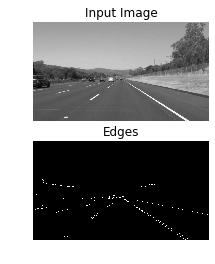

In [15]:
from edge import canny

# Load image
img = io.imread('road.jpg', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)

plt.subplot(211)
plt.imshow(img)
plt.axis('off')
plt.title('Input Image')

plt.subplot(212)
plt.imshow(edges)
plt.axis('off')
plt.title('Edges')
plt.show()

### 2.2 Extracting region of interest (ROI)
We can see that the Canny edge detector could find the edges of the lanes. However, we can also see that there are edges of other objects that we are not interested in. Given the position and orientation of the camera, we know that the lanes will be located in the lower half of the image. The code below defines a binary mask for the ROI and extract the edges within the region.

Sau bước 2.1 ta thấy rằng bộ phát hiện đường biên Canny đã tìm được các biên của làn đường. Tuy nhiên, ta cũng thấy rằng còn rất nhiều đường biên của các đối tượng khác (mặc dù ta không quan tâm) cũng được phát hiện luôn. Với vị trí và góc chụp của camera, ta biết rằng các làn đường chỉ nằm ở nửa dưới của ảnh. Đoạn code bên dưới định nghĩa một mặt nạ nhị phân của vùng ta đang quan tâm (ROI) và trích phần đường biên ở trong vùng này ra mảng **roi**.

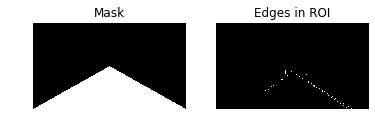

In [16]:
H, W = img.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if i > (H / W) * j and i > -(H / W) * j + H:
            mask[i, j] = 1

# Extract edges in ROI
roi = edges * mask

plt.subplot(1,2,1)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(roi)
plt.title('Edges in ROI')
plt.axis('off')
plt.show()

### 2.3 Fitting lines using Hough transform (15 points)
The output from the edge detector is still a collection of connected points. However, it would be more natural to represent a lane as a line parameterized as $y = ax + b$, with a slope $a$ and y-intercept $b$. We will use Hough transform to find parameterized lines that represent the detected edges.

Đầu ra của bộ phát hiện đường biên là tập hợp các điểm liên thông (dưới dạng ảnh). Tuy nhiên, để đúng với bản chất hơn, ta cần phải biểu diễn làn đường là một đường thẳng có phương trình $y = ax + b$ chứ không phải là danh sách các điểm. Ta sẽ thấy rằng biến đổi Hough cho phép ta tìm các tham số $a$, $b$ của phương trình đường thẳng.

In general, a straight line $y = ax + b$ can be represented as a point $(a, b)$ in the parameter space. However, this cannot represent vertical lines as the slope parameter will be unbounded. Alternatively, we parameterize a line using $\theta\in{[-\pi, \pi]}$ and $\rho\in{\mathbb{R}}$ as follows:

Như ta đã học ở phần lý thuyết, một đường thẳng $y = ax + b$ trong không gian gốc $x,y$ có thể được biểu diễn như là một điểm $(a, b)$ trong không gian tham số. Tuy nhiên, dạng đường thẳng này không thể dùng để biểu diễn các đường thẳng đứng có dạng $x = c$. Thay vì thế, ta sẽ sử dụng phương trình đường thẳng được biểu diễn trong hệ toạ độ cực với hai tham số $\theta\in{[-\pi, \pi]}$ và $\rho\in{\mathbb{R}}$ như sau:

$$
\rho = x\cdot{cos\theta} + y\cdot{sin\theta}
$$

Using this parameterization, we can map everypoint in $xy$-space to a sine-like line in $\theta\rho$-space (or Hough space). We then accumulate the parameterized points in the Hough space and choose points (in Hough space) with highest accumulated values. A point in Hough space then can be transformed back into a line in $xy$-space.


Sử dụng phương trình tham số này, ta có thể ánh xạ/liên kết mỗi điểm trong không gian $xy$ thành một đường (có dạng hình sin) trong không gian tham số $\theta\rho$ (hay còn gọi là không gian Hough). Sau đó, với mỗi điểm (x,y) trong không gian $xy$ thoả mãn phương trình đường thẳng (\rho = x\cdot{cos\theta} + y\cdot{sin\theta}), ta tăng giá trị của ô $(\theta, \rho)$ lên 1. Sau cùng, chọn ô $(\theta, \rho)$ nào có giá trị lớn nhất thì nó chính là tham số của đường thẳng cần tìm. Từ hai giá trị $(\theta, \rho)$ ta có thể chuyển nó về phương trình đường thẳng trong không gian $xy$.

*See [notes](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/HoughTrans_lines_09.pdf) on Hough transform.*

Implement **`hough_transform`** in `edge.py`.

Hãy cài đặt hàm **`hough_transform`** trong `edge.py`.

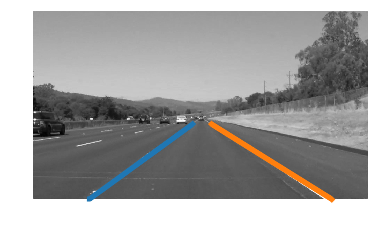

In [17]:
from edge import hough_transform

# Perform Hough transform on the ROI
acc, rhos, thetas = hough_transform(roi)

# Coordinates for right lane
xs_right = []
ys_right = []

# Coordinates for left lane
xs_left = []
ys_left = []

for i in range(20):
    idx = np.argmax(acc)
    r_idx = idx // acc.shape[1]
    t_idx = idx % acc.shape[1]
    acc[r_idx, t_idx] = 0 # Zero out the max value in accumulator

    rho = rhos[r_idx]
    theta = thetas[t_idx]
    
    # Transform a point in Hough space to a line in xy-space.
    a = - (np.cos(theta)/np.sin(theta)) # slope of the line
    b = (rho/np.sin(theta)) # y-intersect of the line

    # Break if both right and left lanes are detected
    if xs_right and xs_left:
        break
    
    if a < 0: # Left lane
        if xs_left:
            continue
        xs = xs_left
        ys = ys_left
    else: # Right Lane
        if xs_right:
            continue
        xs = xs_right
        ys = ys_right

    for x in range(img.shape[1]):
        y = a * x + b
        if y > img.shape[0] * 0.6 and y < img.shape[0]:
            xs.append(x)
            ys.append(int(round(y)))

plt.imshow(img)
plt.plot(xs_left, ys_left, linewidth=5.0)
plt.plot(xs_right, ys_right, linewidth=5.0)
plt.axis('off')
plt.show()